In [1]:
import duckdb
import os


In [20]:
import pandas as pd
from sklearn.linear_model import LinearRegression

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [65]:
import seaborn as sns

In [55]:
from sklearn.decomposition import PCA

In [56]:
import matplotlib.pyplot as plt

In [2]:
con = duckdb.connect(database = ':memory:')

In [8]:
#2023 version: for each provider, we are computing the total estimated medicare dollars contributed for the service they provided(Avg_Mdcr_Pymt_Amt*Tot_Srvcs), then summing across all providers

medicare2023_MedicareTotalPymtByState_df = con.execute("""SELECT HCPCS_Cd, Rndrng_Prvdr_State_Abrvtn, sum(Avg_Mdcr_Pymt_Amt*Tot_Srvcs) / sum(Tot_Srvcs) as est_wght_avg_Mdcr_paid FROM 'medicare_2023.parquet' WHERE Avg_Mdcr_Pymt_Amt IS NOT NULL AND Tot_Srvcs IS NOT NULL GROUP BY HCPCS_Cd, Rndrng_Prvdr_State_Abrvtn;""" ).df()

In [9]:
#2023: total estimated medicare spending per service per state
#this estimates the total amount of money that medicare covered for each service by state
medicare2023_MedicareTotalPymtByState_df

,HCPCS_Cd,Rndrng_Prvdr_State_Abrvtn,est_wght_avg_Mdcr_paid
0,99238,NM,59.917472
1,99213,OH,52.009253
2,72148,NY,117.269928
3,G0444,MO,16.977336
4,99231,OH,36.149224
...,...,...,...
128643,95018,ME,16.279457
128644,53440,AL,556.120000
128645,93314,WY,70.470000
128646,22843,KY,606.392273


In [39]:
medicare2023_MedicareTotalPymtByState_df.dropna()
medicare2023_MedicareTotalPymtByState_df

,HCPCS_Cd,Rndrng_Prvdr_State_Abrvtn,est_wght_avg_Mdcr_paid
0,99238,NM,59.917472
1,99213,OH,52.009253
2,72148,NY,117.269928
3,G0444,MO,16.977336
4,99231,OH,36.149224
...,...,...,...
128643,95018,ME,16.279457
128644,53440,AL,556.120000
128645,93314,WY,70.470000
128646,22843,KY,606.392273


In [40]:
#grabbing the top 50 services for 2023

top50_services2023 = medicare2023_MedicareTotalPymtByState_df['HCPCS_Cd'].value_counts().nlargest(50).index
top50_services2023

Index(['99232', '99223', '99213', '97140', '00731', '99204', '97112', '99233',
       '99283', '99214', '71250', '99203', '99284', '92014', '73502', '99291',
       '70450', '99215', '97530', '92250', '71045', '74176', '97110', '71046',
       '00812', '00142', '74177', 'G0439', '73030', '00811', '99285', 'G0008',
       '72125', '99222', '99212', '99231', '73630', '99239', '76770', '72131',
       'J1100', '76775', '76536', '71260', '92083', '99309', '70486', '74178',
       '72170', '76705'],
      dtype='object', name='HCPCS_Cd')

In [41]:
#the dataframe below shows the top 100 services (the services that were provided most) in 2022

top50Services_2023df = medicare2023_MedicareTotalPymtByState_df[medicare2023_MedicareTotalPymtByState_df['HCPCS_Cd'].isin(top50_services2023)]
top50Services_2023df

,HCPCS_Cd,Rndrng_Prvdr_State_Abrvtn,est_wght_avg_Mdcr_paid
1,99213,OH,52.009253
4,99231,OH,36.149224
6,97140,MN,15.880330
9,99291,NJ,178.870771
13,73630,NE,15.568374
...,...,...,...
127247,97112,SD,21.369952
127545,J1100,NH,0.096340
127599,99203,AE,68.274703
128190,76536,XX,18.676667


In [42]:
encoded_dfTop50Service2023 = pd.get_dummies(top50Services_2023df, columns=['HCPCS_Cd','Rndrng_Prvdr_State_Abrvtn'], drop_first = True, dtype=int)

encoded_dfTop50Service2023

,est_wght_avg_Mdcr_paid,HCPCS_Cd_00731,HCPCS_Cd_00811,HCPCS_Cd_00812,HCPCS_Cd_70450,HCPCS_Cd_70486,HCPCS_Cd_71045,HCPCS_Cd_71046,HCPCS_Cd_71250,HCPCS_Cd_71260,...,Rndrng_Prvdr_State_Abrvtn_UT,Rndrng_Prvdr_State_Abrvtn_VA,Rndrng_Prvdr_State_Abrvtn_VI,Rndrng_Prvdr_State_Abrvtn_VT,Rndrng_Prvdr_State_Abrvtn_WA,Rndrng_Prvdr_State_Abrvtn_WI,Rndrng_Prvdr_State_Abrvtn_WV,Rndrng_Prvdr_State_Abrvtn_WY,Rndrng_Prvdr_State_Abrvtn_XX,Rndrng_Prvdr_State_Abrvtn_ZZ
1,52.009253,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,36.149224,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,15.880330,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,178.870771,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,15.568374,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127247,21.369952,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
127545,0.096340,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
127599,68.274703,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
128190,18.676667,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [43]:
# Define features (X) and target (y), INCLUDES state
X_top50Service2023 = encoded_dfTop50Service2023.drop('est_wght_avg_Mdcr_paid', axis=1)
y_top50Service2023 = encoded_dfTop50Service2023['est_wght_avg_Mdcr_paid']

#Fit the Linear Regression Model:
model = LinearRegression()
model.fit(X_top50Service2023,y_top50Service2023)

LinearRegression()

In [44]:
print(f"\nModel Coefficients: {model.coef_}")
print(f"Model Intercept: {model.intercept_}")


Model Coefficients: [  4.33494891   1.98989373   4.75526474 -50.99442742 -37.62018829
 -74.94133107 -70.31136429 -34.26046878 -34.99919303 -46.12717635
 -41.78117403 -72.41245074 -66.59412468 -63.86322109 -65.39747844
 -13.38127058  -1.38338518  46.89818788 -39.03586856 -55.62374958
 -42.2453239  -53.01567313  -2.56377208 -40.56986186 -57.19246844
 -63.95421371 -60.30868998 -65.79247814 -57.11346569 -12.74203194
  25.51464564 -46.5166447  -25.901877    -2.71519448  32.35920996
  16.1096076   49.94482546 -44.50551733 -21.06281854  10.53913224
   6.07586835 -30.90491085   6.36233243  53.48825107  85.95637513
  -8.88937468 -53.33362082  34.0963841  -81.74302049   9.35160913
  23.62812227   0.95116534   5.49942685   0.94544342 -11.08175389
   9.33599577  15.17606133   5.27224275   8.95129838  13.72210699
   6.51639846  10.88288285   5.15291515   3.85453486  11.68031775
   7.63653494   1.88848929   0.62623402   6.63491827   1.96944985
   1.97738399   1.207946     3.20370275   5.54045004  1

In [45]:
#R Squared Service and State
r_squared_top50Services2023 = model.score(X_top50Service2023,y_top50Service2023)
r_squared_top50Services2023

0.9551648515578087

In [46]:
# Define features (X) and target (y), EXCLUDES state, only considers service

#columns_to_drop = ['est_wght_avg_Mdcr_paid','Rndrng_Prvdr_State_Abrvtn']
#X_top50ServiceONLY2022 = encoded_dfTop50Service2022.drop(columns=columns_to_drop)

X_top50ServiceONLY2023 = encoded_dfTop50Service2023.filter(like='HCPCS_Cd_')
y_top50ServiceONLY2023 = encoded_dfTop50Service2023['est_wght_avg_Mdcr_paid']

#Fit the Linear Regression Model:
model = LinearRegression()
model.fit(X_top50ServiceONLY2023,y_top50ServiceONLY2023)

LinearRegression()

In [47]:
print(f"\nModel Coefficients: {model.coef_}")
print(f"Model Intercept: {model.intercept_}")


Model Coefficients: [  4.24838466   1.92263704   4.68800805 -51.06168411 -37.76028999
 -75.00858776 -70.37862097 -34.32772547 -35.13929472 -46.19443304
 -41.92127573 -72.55255244 -66.66138137 -63.93047778 -65.37130071
 -13.44852727  -1.45064187  46.77666518 -39.17597025 -55.76385127
 -42.3854256  -52.9894954   -2.66508872 -40.67819381 -57.29378508
 -63.94925443 -60.39525424 -65.8790424  -57.18072238 -12.80928862
  25.42808138 -46.5166447  -25.98844126  -2.80175874  32.35920996
  16.1096076   49.85900914 -44.51903159 -21.14863485  10.43882188
   5.89514512 -31.27579903   6.00593277  53.1318514   85.88911844
  -8.94248109 -53.33362082  34.0963841  -81.72188754]
Model Intercept: 81.81565345686718


In [48]:
#R Squared service only 2023
r_squared_top50ServiceONLY2023 = model.score(X_top50ServiceONLY2023,y_top50ServiceONLY2023)
r_squared_top50ServiceONLY2023

0.9390217021099313

In [81]:
df_service_2023 =(
    top50Services_2023df.groupby('HCPCS_Cd', as_index=False)[['est_wght_avg_Mdcr_paid']].mean()
)

df_service_2023

,HCPCS_Cd,est_wght_avg_Mdcr_paid
0,00142,81.815653
1,00731,86.064038
2,00811,83.738290
3,00812,86.503662
4,70450,30.753969
5,70486,44.055363
6,71045,6.807066
7,71046,11.437032
8,71250,47.487928
9,71260,46.676359


In [82]:
X = df_service_2023[['est_wght_avg_Mdcr_paid']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 0.59896577],
       [ 0.70810537],
       [ 0.64835768],
       [ 0.71939915],
       [-0.71279207],
       [-0.37108364],
       [-1.32798014],
       [-1.20903781],
       [-0.28290219],
       [-0.30375113],
       [-0.58775399],
       [-0.47797799],
       [-1.2648854 ],
       [-1.11354315],
       [-1.04338714],
       [-1.08040141],
       [ 0.25347754],
       [ 0.56169926],
       [ 1.80064289],
       [-0.407452  ],
       [-0.8335892 ],
       [-0.48990185],
       [-0.76231691],
       [ 0.53050052],
       [-0.44604363],
       [-0.87289269],
       [-1.04386951],
       [-0.95256841],
       [-1.09344512],
       [-0.86998815],
       [ 0.26989937],
       [ 1.2522048 ],
       [-0.59603151],
       [-0.06866872],
       [ 0.52698951],
       [ 1.43026321],
       [ 1.01281628],
       [ 1.87982729],
       [-0.54471348],
       [ 0.05566431],
       [ 0.86713567],
       [ 0.75041011],
       [-0.2044992 ],
       [ 0.7532562 ],
       [ 1.96390553],
       [ 2

In [83]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_service_2023['cluster'] = kmeans.fit_predict(X_scaled)
df_service_2023

,HCPCS_Cd,est_wght_avg_Mdcr_paid,cluster
0,00142,81.815653,2
1,00731,86.064038,2
2,00811,83.738290,2
3,00812,86.503662,2
4,70450,30.753969,1
5,70486,44.055363,1
6,71045,6.807066,1
7,71046,11.437032,1
8,71250,47.487928,1
9,71260,46.676359,1


In [84]:
df_long = pd.melt(df_service_2023, id_vars=['HCPCS_Cd', 'cluster'],
                  var_name='est_wght_avg_Mdcr_paid', value_name='mean_value')

df_long

,HCPCS_Cd,cluster,est_wght_avg_Mdcr_paid,mean_value
0,00142,2,est_wght_avg_Mdcr_paid,81.815653
1,00731,2,est_wght_avg_Mdcr_paid,86.064038
2,00811,2,est_wght_avg_Mdcr_paid,83.738290
3,00812,2,est_wght_avg_Mdcr_paid,86.503662
4,70450,1,est_wght_avg_Mdcr_paid,30.753969
5,70486,1,est_wght_avg_Mdcr_paid,44.055363
6,71045,1,est_wght_avg_Mdcr_paid,6.807066
7,71046,1,est_wght_avg_Mdcr_paid,11.437032
8,71250,1,est_wght_avg_Mdcr_paid,47.487928
9,71260,1,est_wght_avg_Mdcr_paid,46.676359


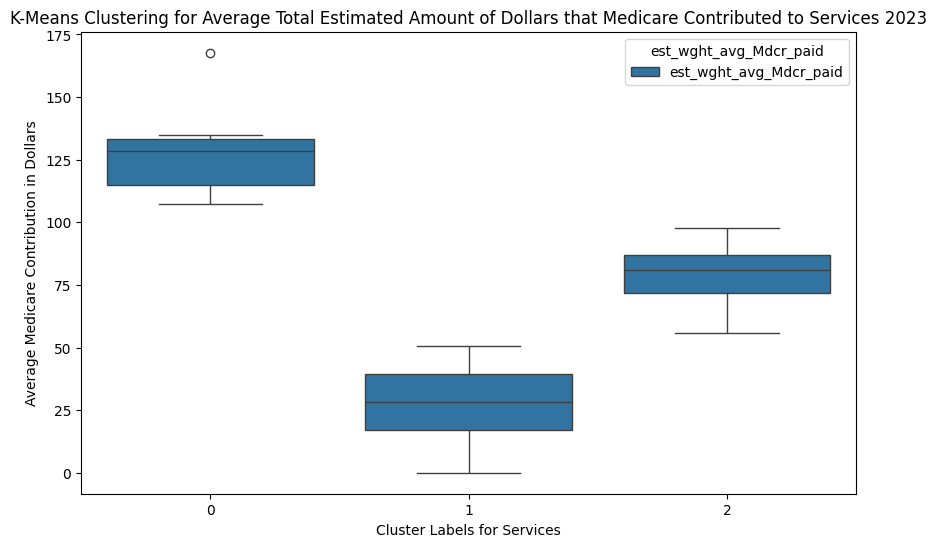

In [85]:
#here is the box plot for k means clustering on average amount of money in dollars that medicare contributed to services, grouped on services variable
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='mean_value', hue='est_wght_avg_Mdcr_paid', data=df_long)
plt.title('K-Means Clustering for Average Total Estimated Amount of Dollars that Medicare Contributed to Services 2023')
plt.ylabel('Average Medicare Contribution in Dollars')
plt.xlabel('Cluster Labels for Services')
plt.show()

In [10]:
#2022 version: for each provider, we are computing the total estimated medicare dollars contributed for the service they provided (Avg_Mdcr_Pymt_Amt*Tot_Srvcs), then summing across all providers

medicare2022_MedicareTotalPymtByState_df = con.execute("""SELECT HCPCS_Cd, Rndrng_Prvdr_State_Abrvtn, sum(Avg_Mdcr_Pymt_Amt*Tot_Srvcs) / sum(Tot_Srvcs) as est_wght_avg_Mdcr_paid FROM 'medicare_2022.parquet' WHERE Avg_Mdcr_Pymt_Amt IS NOT NULL AND Tot_Srvcs IS NOT NULL GROUP BY HCPCS_Cd, Rndrng_Prvdr_State_Abrvtn;""" ).df()

In [11]:
#2022: total estimated medicare spending per service per state

medicare2022_MedicareTotalPymtByState_df

,HCPCS_Cd,Rndrng_Prvdr_State_Abrvtn,est_wght_avg_Mdcr_paid
0,99204,OH,106.242729
1,92004,TX,93.365551
2,Q9967,CA,0.091704
3,93976,LA,36.684412
4,76536,PA,32.718329
...,...,...,...
130045,80198,SD,13.990667
130046,82232,SD,15.938699
130047,92541,WA,19.088462
130048,80195,IA,13.574747


In [13]:
medicare2022_MedicareTotalPymtByState_df.dropna()

,HCPCS_Cd,Rndrng_Prvdr_State_Abrvtn,est_wght_avg_Mdcr_paid
0,99204,OH,106.242729
1,92004,TX,93.365551
2,Q9967,CA,0.091704
3,93976,LA,36.684412
4,76536,PA,32.718329
...,...,...,...
130045,80198,SD,13.990667
130046,82232,SD,15.938699
130047,92541,WA,19.088462
130048,80195,IA,13.574747


In [26]:
#grabbing the top 50 services

top50_services = medicare2022_MedicareTotalPymtByState_df['HCPCS_Cd'].value_counts().nlargest(50).index
top50_services

Index(['99232', '99223', '99204', '00811', '00731', '99239', '99283', 'G0008',
       '99214', '99222', '99213', '97140', 'G0439', '71046', '92134', '99233',
       '97112', '74018', '99215', '99291', '70450', '96372', '74176', '76705',
       '97530', '76770', '73562', '92250', '97110', '72125', '74177', '99284',
       '00142', '97162', '99212', '36415', '00812', '99285', '99203', '76536',
       '93970', '71045', '99282', 'G0283', '73030', '81003', '73502', '83036',
       '70486', '81002'],
      dtype='object', name='HCPCS_Cd')

In [27]:
#the dataframe below shows the top 100 services (the services that were provided most) in 2022

top50Services_2022df = medicare2022_MedicareTotalPymtByState_df[medicare2022_MedicareTotalPymtByState_df['HCPCS_Cd'].isin(top50_services)]
top50Services_2022df

,HCPCS_Cd,Rndrng_Prvdr_State_Abrvtn,est_wght_avg_Mdcr_paid
0,99204,OH,106.242729
4,76536,PA,32.718329
5,99285,SC,138.956436
7,73030,CO,17.116331
8,97162,MI,73.899678
...,...,...,...
129012,76536,ND,27.981670
129168,70486,PR,37.877034
129377,99215,XX,119.930588
129514,73562,GU,15.232113


In [28]:
encoded_dfTop50Service2022 = pd.get_dummies(top50Services_2022df, columns=['HCPCS_Cd','Rndrng_Prvdr_State_Abrvtn'], drop_first = True, dtype=int)

encoded_dfTop50Service2022

,est_wght_avg_Mdcr_paid,HCPCS_Cd_00731,HCPCS_Cd_00811,HCPCS_Cd_00812,HCPCS_Cd_36415,HCPCS_Cd_70450,HCPCS_Cd_70486,HCPCS_Cd_71045,HCPCS_Cd_71046,HCPCS_Cd_72125,...,Rndrng_Prvdr_State_Abrvtn_UT,Rndrng_Prvdr_State_Abrvtn_VA,Rndrng_Prvdr_State_Abrvtn_VI,Rndrng_Prvdr_State_Abrvtn_VT,Rndrng_Prvdr_State_Abrvtn_WA,Rndrng_Prvdr_State_Abrvtn_WI,Rndrng_Prvdr_State_Abrvtn_WV,Rndrng_Prvdr_State_Abrvtn_WY,Rndrng_Prvdr_State_Abrvtn_XX,Rndrng_Prvdr_State_Abrvtn_ZZ
0,106.242729,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,32.718329,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,138.956436,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,17.116331,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,73.899678,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129012,27.981670,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129168,37.877034,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129377,119.930588,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
129514,15.232113,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# Define features (X) and target (y), INCLUDES state
X_top50Service2022 = encoded_dfTop50Service2022.drop('est_wght_avg_Mdcr_paid', axis=1)
y_top50Service2022 = encoded_dfTop50Service2022['est_wght_avg_Mdcr_paid']

#Fit the Linear Regression Model:
model = LinearRegression()
model.fit(X_top50Service2022,y_top50Service2022)

LinearRegression()

In [30]:
print(f"\nModel Coefficients: {model.coef_}")
print(f"Model Intercept: {model.intercept_}")


Model Coefficients: [ 3.54928896e+00  1.77801925e+00  3.53298917e+00 -8.19332058e+01
 -5.38590533e+01 -4.10920945e+01 -7.80629635e+01 -7.33989972e+01
 -4.85086387e+01 -6.97620692e+01 -6.71594939e+01 -6.61899825e+01
 -7.65885939e+01 -1.59424195e+01 -2.56223210e+00 -4.14422651e+01
 -5.89935267e+01 -4.56943289e+01 -8.15335924e+01 -8.26676828e+01
 -7.54009102e+01 -5.67425141e+01 -6.03149717e+01 -2.56353461e+01
 -7.48284566e+01 -6.64876228e+01 -6.25617599e+01 -6.84658822e+01
 -1.15638257e+01 -5.95902186e+01 -1.39489481e+01  2.58116619e+01
 -4.96501501e+01 -2.83534676e+01 -4.80543565e+00  3.20279197e+01
  1.79100227e+01  6.68298417e+01 -2.96622582e+01 -5.19238828e+00
 -3.33840075e+00 -5.52855250e+01 -3.22840785e+01  7.51527334e+00
  5.95433755e+01  9.18349009e+01 -5.95113409e+01 -7.77999458e+01
  3.41347964e+01  4.63021259e+00  2.12776440e+01  4.97016240e-01
  2.25051388e+00 -8.70200778e-02 -1.31315122e+01  6.89700384e+00
  1.22774698e+01  3.84859407e+00  7.41986761e+00  1.15860193e+01
  5.

In [31]:
r_squared_top50Services2022 = model.score(X_top50Service2022,y_top50Service2022)

In [32]:
r_squared_top50Services2022

0.9719378402257992

In [36]:
# Define features (X) and target (y), EXCLUDES state, only considers service

#columns_to_drop = ['est_wght_avg_Mdcr_paid','Rndrng_Prvdr_State_Abrvtn']
#X_top50ServiceONLY2022 = encoded_dfTop50Service2022.drop(columns=columns_to_drop)

X_top50ServiceONLY2022 = encoded_dfTop50Service2022.filter(like='HCPCS_Cd_')
y_top50ServiceONLY2022 = encoded_dfTop50Service2022['est_wght_avg_Mdcr_paid']

#Fit the Linear Regression Model:
model = LinearRegression()
model.fit(X_top50ServiceONLY2022,y_top50ServiceONLY2022)

LinearRegression()

In [37]:
print(f"\nModel Coefficients: {model.coef_}")
print(f"Model Intercept: {model.intercept_}")


Model Coefficients: [  3.48399557   1.71272586   3.46609224 -82.00010277 -53.93753149
 -41.17243124 -78.08139685 -73.46429056 -48.58711684 -69.84240592
 -67.23983061 -66.26846064 -76.66707207 -16.0208977   -2.64071028
 -41.52260179 -59.07200486 -45.77280712 -81.5340978  -82.74460169
 -75.40756264 -56.81763249 -60.39009004 -25.65377943 -74.89535358
 -66.49366562 -62.73076812 -68.5311756  -11.56986844 -59.65711551
 -14.01584507  25.74636854 -49.65015012 -28.41876099  -4.87072903
  32.02791971  17.84472932  66.69380808 -29.79829183  -5.25928522
  -3.48857846 -55.3742249  -32.6420968    7.15069006  59.17879225
  91.76800396 -59.57663424 -77.85103415  34.06950297]
Model Intercept: 84.95327175595293


In [38]:
r_squared_top50ServiceONLY2022 = model.score(X_top50ServiceONLY2022,y_top50ServiceONLY2022)
r_squared_top50ServiceONLY2022

0.9615426075543878

Applying K Means Cluster on est_wght_avg_Mdcr_paid variable to visually show that there is variation in payment per service but not variation in payment per state

In [52]:
#making a copy of the dataframe for k means cluster: clustering solely based off of payment
top50Services_2022df_COPY = top50Services_2022df.copy()
totalMedicarePaymentFeature = top50Services_2022df_COPY[['est_wght_avg_Mdcr_paid']]
scaler = StandardScaler()
scaled = scaler.fit_transform(totalMedicarePaymentFeature)

In [53]:
kmeans = KMeans(n_clusters=3, random_state=42)
top50Services_2022df_COPY['cluster'] = kmeans.fit_predict(scaled)

In [54]:
top50Services_2022df_COPY

,HCPCS_Cd,Rndrng_Prvdr_State_Abrvtn,est_wght_avg_Mdcr_paid,cluster
0,99204,OH,106.242729,0
4,76536,PA,32.718329,2
5,99285,SC,138.956436,1
7,73030,CO,17.116331,2
8,97162,MI,73.899678,0
...,...,...,...,...
129012,76536,ND,27.981670,2
129168,70486,PR,37.877034,2
129377,99215,XX,119.930588,1
129514,73562,GU,15.232113,2


Text(0.5, 0, 'Total Amount of Money Medicare Contributes to Services')

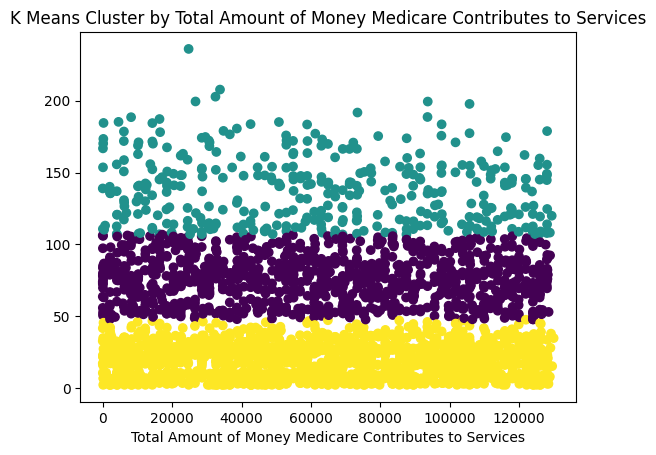

In [59]:
plt.scatter(top50Services_2022df_COPY.index, top50Services_2022df_COPY['est_wght_avg_Mdcr_paid'], c=top50Services_2022df_COPY['cluster'])

plt.title("K Means Cluster by Total Amount of Money Medicare Contributes to Services")
plt.xlabel("Total Amount of Money Medicare Contributes to Services")

In [86]:
df_service_2022 =(
    top50Services_2022df.groupby('HCPCS_Cd', as_index=False)[['est_wght_avg_Mdcr_paid']].mean()
)

df_service_2022

,HCPCS_Cd,est_wght_avg_Mdcr_paid
0,00142,84.953272
1,00731,88.437267
2,00811,86.665998
3,00812,88.419364
4,36415,2.953169
5,70450,31.015740
6,70486,43.780841
7,71045,6.871875
8,71046,11.488981
9,72125,36.366155


In [87]:
X = df_service_2022[['est_wght_avg_Mdcr_paid']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 0.73767008],
       [ 0.81970038],
       [ 0.77799603],
       [ 0.81927885],
       [-1.19301339],
       [-0.53228321],
       [-0.23173032],
       [-1.10074788],
       [-0.99203862],
       [-0.40630828],
       [-0.90676174],
       [-0.84548439],
       [-0.82261359],
       [-1.06744776],
       [ 0.36045979],
       [ 0.67549485],
       [-0.23997504],
       [-0.65317382],
       [-0.34004566],
       [-1.18204135],
       [-1.21054253],
       [-1.03779275],
       [-0.60009487],
       [-0.684208  ],
       [ 0.13365465],
       [-1.02573284],
       [-0.82791602],
       [-0.73931901],
       [-0.87588897],
       [ 0.46525879],
       [-0.66695019],
       [ 0.40766854],
       [ 1.34386552],
       [-0.43133728],
       [ 0.06855346],
       [ 0.6229893 ],
       [ 1.49176395],
       [ 1.15782229],
       [ 2.30796851],
       [ 0.03607255],
       [ 0.61384079],
       [ 0.65553188],
       [-0.56611   ],
       [-0.03088452],
       [ 0.9060323 ],
       [ 2

In [88]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_service_2022['cluster'] = kmeans.fit_predict(X_scaled)
df_service_2022

,HCPCS_Cd,est_wght_avg_Mdcr_paid,cluster
0,00142,84.953272,2
1,00731,88.437267,2
2,00811,86.665998,2
3,00812,88.419364,2
4,36415,2.953169,0
5,70450,31.015740,0
6,70486,43.780841,0
7,71045,6.871875,0
8,71046,11.488981,0
9,72125,36.366155,0


In [89]:
df_long = pd.melt(df_service_2022, id_vars=['HCPCS_Cd', 'cluster'],
                  var_name='est_wght_avg_Mdcr_paid', value_name='mean_value')

df_long

,HCPCS_Cd,cluster,est_wght_avg_Mdcr_paid,mean_value
0,00142,2,est_wght_avg_Mdcr_paid,84.953272
1,00731,2,est_wght_avg_Mdcr_paid,88.437267
2,00811,2,est_wght_avg_Mdcr_paid,86.665998
3,00812,2,est_wght_avg_Mdcr_paid,88.419364
4,36415,0,est_wght_avg_Mdcr_paid,2.953169
5,70450,0,est_wght_avg_Mdcr_paid,31.015740
6,70486,0,est_wght_avg_Mdcr_paid,43.780841
7,71045,0,est_wght_avg_Mdcr_paid,6.871875
8,71046,0,est_wght_avg_Mdcr_paid,11.488981
9,72125,0,est_wght_avg_Mdcr_paid,36.366155


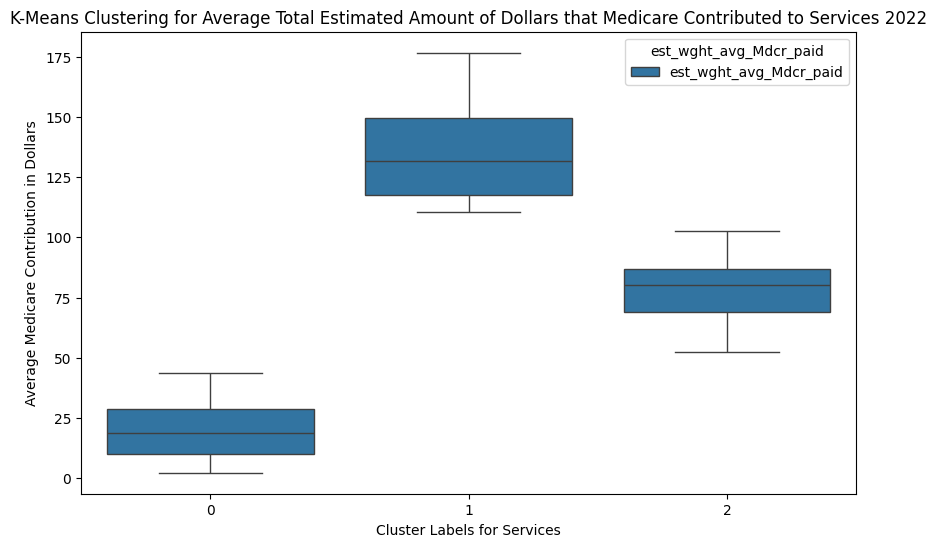

In [90]:
#here is the box plot for k means clustering on average amount of money in dollars that medicare contributed to services, grouped on services variable
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='mean_value', hue='est_wght_avg_Mdcr_paid', data=df_long)
plt.title('K-Means Clustering for Average Total Estimated Amount of Dollars that Medicare Contributed to Services 2022')
plt.ylabel('Average Medicare Contribution in Dollars')
plt.xlabel('Cluster Labels for Services')
plt.show()

In [76]:
df_service_2022State =(
    top50Services_2022df.groupby('Rndrng_Prvdr_State_Abrvtn', as_index=False)[['est_wght_avg_Mdcr_paid']].mean()
)

df_service_2022State

,Rndrng_Prvdr_State_Abrvtn,est_wght_avg_Mdcr_paid
0,AA,49.227175
1,AE,63.410438
2,AK,71.066382
3,AL,50.285755
4,AP,52.989314
...,...,...
57,WI,49.072964
58,WV,48.250270
59,WY,54.708172
60,XX,54.255782


In [77]:
X = df_service_2022State[['est_wght_avg_Mdcr_paid']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.77961867],
       [ 1.17375407],
       [ 2.22815978],
       [-0.63382712],
       [-0.26148269],
       [-0.71426282],
       [ 3.38907458],
       [ 0.24760346],
       [ 0.98862165],
       [-0.17223511],
       [ 0.31961424],
       [ 0.89339246],
       [ 0.05316117],
       [ 0.4580186 ],
       [ 5.09045047],
       [-0.31885937],
       [ 0.75904901],
       [ 0.05043882],
       [-0.54957656],
       [-0.73034176],
       [ 0.0622927 ],
       [-0.54792242],
       [-0.61163095],
       [-0.5772084 ],
       [-0.2613455 ],
       [-0.06242224],
       [ 0.84414018],
       [-0.81275103],
       [-0.50876269],
       [-0.56672136],
       [-0.59700511],
       [-0.02836657],
       [-0.6036518 ],
       [-0.38472278],
       [-0.41132545],
       [-0.81953215],
       [-0.74233812],
       [-0.42851429],
       [ 0.95271517],
       [-0.26958358],
       [ 0.34371509],
       [ 1.20323564],
       [-0.67003625],
       [-0.64541969],
       [-0.35822318],
       [-0

In [78]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_service_2022State['cluster'] = kmeans.fit_predict(X_scaled)
df_service_2022State

,Rndrng_Prvdr_State_Abrvtn,est_wght_avg_Mdcr_paid,cluster
0,AA,49.227175,0
1,AE,63.410438,1
2,AK,71.066382,1
3,AL,50.285755,0
4,AP,52.989314,0
...,...,...,...
57,WI,49.072964,0
58,WV,48.250270,0
59,WY,54.708172,0
60,XX,54.255782,0


In [79]:
df_long = pd.melt(df_service_2022State, id_vars=['Rndrng_Prvdr_State_Abrvtn', 'cluster'],
                  var_name='est_wght_avg_Mdcr_paid', value_name='mean_value')

df_long

,Rndrng_Prvdr_State_Abrvtn,cluster,est_wght_avg_Mdcr_paid,mean_value
0,AA,0,est_wght_avg_Mdcr_paid,49.227175
1,AE,1,est_wght_avg_Mdcr_paid,63.410438
2,AK,1,est_wght_avg_Mdcr_paid,71.066382
3,AL,0,est_wght_avg_Mdcr_paid,50.285755
4,AP,0,est_wght_avg_Mdcr_paid,52.989314
...,...,...,...,...
57,WI,0,est_wght_avg_Mdcr_paid,49.072964
58,WV,0,est_wght_avg_Mdcr_paid,48.250270
59,WY,0,est_wght_avg_Mdcr_paid,54.708172
60,XX,0,est_wght_avg_Mdcr_paid,54.255782


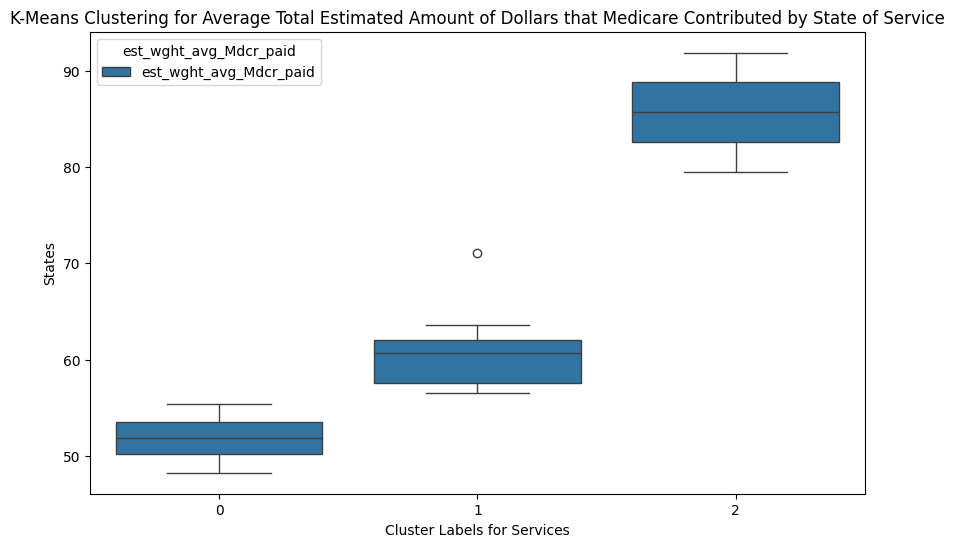

In [80]:
#here is the box plot for k means clustering on average amount of money in dollars that medicare contributed to services, grouped on services variable
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='mean_value', hue='est_wght_avg_Mdcr_paid', data=df_long)
plt.title('K-Means Clustering for Average Total Estimated Amount of Dollars that Medicare Contributed by State of Service')
plt.ylabel('States')
plt.xlabel('Cluster Labels for Services')
plt.show()

Working with the Part B and Part D Datasets Now

In [109]:
Medicare_PartD_SpendingByDrug_df = pd.read_excel("Medicare_Part_D_SpendingByDrug.xlsx")
Medicare_PartD_SpendingByDrug_df

,Brnd_Name,Gnrc_Name,Tot_Mftr,Mftr_Name,Tot_Spndng_2019,Tot_Dsg_Unts_2019,Tot_Clms_2019,Tot_Benes_2019,Avg_Spnd_Per_Dsg_Unt_Wghtd_2019,Avg_Spnd_Per_Clm_2019,...,Tot_Spndng_2023,Tot_Dsg_Unts_2023,Tot_Clms_2023,Tot_Benes_2023,Avg_Spnd_Per_Dsg_Unt_Wghtd_2023,Avg_Spnd_Per_Clm_2023,Avg_Spnd_Per_Bene_2023,Outlier_Flag_2023,Chg_Avg_Spnd_Per_Dsg_Unt_22_23,CAGR_Avg_Spnd_Per_Dsg_Unt_19_23
0,1st Tier Unifine Pentips,"Pen Needle, Diabetic",1,Overall,139201.68,642471.0,5392.0,1878.0,0.216788,25.816335,...,44355.04,195672.0,1613,699.0,0.227162,27.498475,63.454993,0.0,0.005702,0.011754
1,1st Tier Unifine Pentips,"Pen Needle, Diabetic",1,Owen Mumford Us,139201.68,642471.0,5392.0,1878.0,0.216788,25.816335,...,44355.04,195672.0,1613,699.0,0.227162,27.498475,63.454993,0.0,0.005702,0.011754
2,1st Tier Unifine Pentips Plus,"Pen Needle, Diabetic",1,Overall,343031.42,1830596.0,14581.0,5319.0,0.187389,23.525919,...,97951.18,406617.0,3269,1267.0,0.240932,29.963652,77.309534,0.0,0.022165,0.064848
3,1st Tier Unifine Pentips Plus,"Pen Needle, Diabetic",1,Owen Mumford Us,343031.42,1830596.0,14581.0,5319.0,0.187389,23.525919,...,97951.18,406617.0,3269,1267.0,0.240932,29.963652,77.309534,0.0,0.022165,0.064848
4,Abacavir,Abacavir Sulfate,5,Overall,10110328.45,3316293.0,42629.0,6085.0,3.482725,237.170200,...,5287295.41,1648593.0,19632,2809.0,3.594357,269.320263,1882.269637,0.0,-0.071481,0.007919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14304,Zyvox,Linezolid,1,Overall,652488.55,5419.0,110.0,69.0,213.322618,5931.714091,...,50085.86,670.0,30,26.0,74.755015,1669.528667,1926.379231,1.0,-0.138851,-0.230602
14305,Zyvox,Linezolid,1,Pharmacia-Upjhn,652488.55,5419.0,110.0,69.0,213.322618,5931.714091,...,50085.86,670.0,30,26.0,74.755015,1669.528667,1926.379231,1.0,-0.138851,-0.230602
14306,Zyvox,Linezolid In Dextrose 5%,2,Overall,116364.60,564610.0,202.0,105.0,0.205186,576.062376,...,29011.27,185700.0,85,32.0,0.156035,341.309059,906.602188,0.0,-0.050758,-0.066168
14307,Zyvox,Linezolid In Dextrose 5%,1,Pharmacia-Upjhn,97241.77,454210.0,158.0,88.0,0.214090,615.454241,...,21614.77,137400.0,59,25.0,0.157313,366.352034,864.590800,0.0,-0.029488,-0.074147


In [116]:
Medicare_PartB_SpendingByDrug_df = pd.read_excel("Medicare_Part_B_SpendingByDrug.xlsx")

Medicare_PartB_SpendingByDrug_df

,HCPCS_Cd,HCPCS_Desc,Brnd_Name,Gnrc_Name,Tot_Spndng_2019,Tot_Dsg_Unts_2019,Tot_Clms_2019,Tot_Benes_2019,Avg_Spndng_Per_Dsg_Unt_2019,Avg_Spndng_Per_Clm_2019,...,Tot_Dsg_Unts_2023,Tot_Clms_2023,Tot_Benes_2023,Avg_Spndng_Per_Dsg_Unt_2023,Avg_Spndng_Per_Clm_2023,Avg_Spndng_Per_Bene_2023,Outlier_Flag_2023,Avg_DY23_ASP_Price,Chg_Avg_Spndng_Per_Dsg_Unt_22_23,CAGR_Avg_Spnd_Per_Dsg_Unt_19_23
0,90371,Hepatitis b immune globulin for injection into...,HyperHEP B*,Hepatitis B Immune Globulin*,133840.00,1253.0,312.0,161.0,106.815642,428.974359,...,550.0,142,59.0,129.610418,502.012183,1208.232712,0,133.53350,-0.045204,0.049545
1,90375,Rabies immune globulin for injection,HyperRAB*,Rabies Immune Globulin/PF*,9387991.58,33961.0,3395.0,3366.0,276.434486,2765.240524,...,34896.0,3388,3369.0,289.870575,2985.632698,3002.470638,0,294.21400,0.044689,0.011936
2,90376,Rabies immune globulin for injection beneath t...,Imogam Rabies-HT,Rabies Immune Globulin/PF,1258402.96,4708.0,498.0,491.0,267.290348,2526.913574,...,1791.0,207,207.0,268.687398,2324.730097,2324.730097,0,259.64950,-0.201161,0.001304
3,90377,Rabies immune globulin for injection beneath t...,Kedrab,Rabies Immune Globulin/PF,NaN,NaN,NaN,NaN,NaN,NaN,...,8585.0,864,862.0,235.154436,2336.575035,2341.996323,0,240.97325,0.015076,0.023275
4,90632,Hepatitis a vaccine adult dosage,Havrix*,Hepatitis A Virus Vaccine/PF*,80365.23,1408.0,1408.0,1318.0,57.077578,57.077578,...,91.0,91,89.0,84.566044,84.566044,86.466404,1,70.55075,0.316677,0.103272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,Q9965,"Low osmolar contrast material, 100-199 mg/ml i...",Omnipaque,Iohexol,497015.66,662550.0,34305.0,22637.0,0.750156,14.488141,...,1505272.4,56347,23258.0,1.224842,32.720825,79.272522,0,1.35500,0.618339,0.130400
730,Q9966,"Low osmolar contrast material, 200-299 mg/ml i...",Iodixanol (Q9966)*,Iodixanol*,1773023.78,5722774.8,344855.0,172458.0,0.309819,5.141360,...,4190689.2,262346,144372.0,0.432924,6.915482,12.566488,0,0.43950,0.291761,0.087241
731,Q9967,"Low osmolar contrast material, 300-399 mg/ml i...",Iodixanol (Q9967)*,Iodixanol*,11267562.59,97660255.9,1256162.0,920889.0,0.115375,8.969832,...,96084497.6,1225867,916303.0,0.148452,11.635802,15.566844,0,0.15000,0.258775,0.065046
732,Q9991,"Injection, buprenorphine extended-release (sub...",Sublocade (Q9991),Buprenorphine,294179.57,185.0,185.0,45.0,1590.159838,1590.159838,...,623.0,623,146.0,1661.877785,1661.877785,7091.437397,0,1848.25600,-0.009764,0.011089


In [141]:

#Average Spending Per Dosage Unit Part B

partB_avgspend_perdsg_cols = [
    'Avg_Spndng_Per_Dsg_Unt_2019',
    'Avg_Spndng_Per_Dsg_Unt_2020',
    'Avg_Spndng_Per_Dsg_Unt_2021',
    'Avg_Spndng_Per_Dsg_Unt_2022',
    'Avg_Spndng_Per_Dsg_Unt_2023']


partB_long_avgspend_perdsg = Medicare_PartB_SpendingByDrug_df.melt(
    id_vars=['Gnrc_Name'],
    value_vars=partB_avgspend_perdsg_cols,
    var_name='Year',
    value_name='Avg_Spend_Per_Unit'
)

partB_long_avgspend_perdsg['Part'] = 'B'


partB_long_avgspend_perdsg



,Gnrc_Name,Year,Avg_Spend_Per_Unit,Part
0,Hepatitis B Immune Globulin*,Avg_Spndng_Per_Dsg_Unt_2019,106.815642,B
1,Rabies Immune Globulin/PF*,Avg_Spndng_Per_Dsg_Unt_2019,276.434486,B
2,Rabies Immune Globulin/PF,Avg_Spndng_Per_Dsg_Unt_2019,267.290348,B
3,Rabies Immune Globulin/PF,Avg_Spndng_Per_Dsg_Unt_2019,NaN,B
4,Hepatitis A Virus Vaccine/PF*,Avg_Spndng_Per_Dsg_Unt_2019,57.077578,B
...,...,...,...,...
3665,Iohexol,Avg_Spndng_Per_Dsg_Unt_2023,1.224842,B
3666,Iodixanol*,Avg_Spndng_Per_Dsg_Unt_2023,0.432924,B
3667,Iodixanol*,Avg_Spndng_Per_Dsg_Unt_2023,0.148452,B
3668,Buprenorphine,Avg_Spndng_Per_Dsg_Unt_2023,1661.877785,B


In [142]:
partB_long_avgspend_perdsg.dropna()

,Gnrc_Name,Year,Avg_Spend_Per_Unit,Part
0,Hepatitis B Immune Globulin*,Avg_Spndng_Per_Dsg_Unt_2019,106.815642,B
1,Rabies Immune Globulin/PF*,Avg_Spndng_Per_Dsg_Unt_2019,276.434486,B
2,Rabies Immune Globulin/PF,Avg_Spndng_Per_Dsg_Unt_2019,267.290348,B
4,Hepatitis A Virus Vaccine/PF*,Avg_Spndng_Per_Dsg_Unt_2019,57.077578,B
5,Flu Vacc TS2017-18(65yr Up)/PF*,Avg_Spndng_Per_Dsg_Unt_2019,51.745178,B
...,...,...,...,...
3665,Iohexol,Avg_Spndng_Per_Dsg_Unt_2023,1.224842,B
3666,Iodixanol*,Avg_Spndng_Per_Dsg_Unt_2023,0.432924,B
3667,Iodixanol*,Avg_Spndng_Per_Dsg_Unt_2023,0.148452,B
3668,Buprenorphine,Avg_Spndng_Per_Dsg_Unt_2023,1661.877785,B


In [139]:
#keep data from here
#Average Spending Per Dosage Unit Part D
partD_avgspend_perdsg_cols = [
    'Avg_Spnd_Per_Dsg_Unt_Wghtd_2019',
    'Avg_Spnd_Per_Dsg_Unt_Wghtd_2020',
    'Avg_Spnd_Per_Dsg_Unt_Wghtd_2021',
    'Avg_Spnd_Per_Dsg_Unt_Wghtd_2022',
    'Avg_Spnd_Per_Dsg_Unt_Wghtd_2023']


partD_long_avgspend_perdsg = Medicare_PartD_SpendingByDrug_df.melt(
    id_vars=['Gnrc_Name'],
    value_vars=partD_avgspend_perdsg_cols,
    var_name='Year',
    value_name='Avg_Spend_Per_Unit'
)

partD_long_avgspend_perdsg['Part'] = 'D'

partD_long_avgspend_perdsg

,Gnrc_Name,Year,Avg_Spend_Per_Unit,Part
0,"Pen Needle, Diabetic",Avg_Spnd_Per_Dsg_Unt_Wghtd_2019,0.216788,D
1,"Pen Needle, Diabetic",Avg_Spnd_Per_Dsg_Unt_Wghtd_2019,0.216788,D
2,"Pen Needle, Diabetic",Avg_Spnd_Per_Dsg_Unt_Wghtd_2019,0.187389,D
3,"Pen Needle, Diabetic",Avg_Spnd_Per_Dsg_Unt_Wghtd_2019,0.187389,D
4,Abacavir Sulfate,Avg_Spnd_Per_Dsg_Unt_Wghtd_2019,3.482725,D
...,...,...,...,...
71540,Linezolid,Avg_Spnd_Per_Dsg_Unt_Wghtd_2023,74.755015,D
71541,Linezolid,Avg_Spnd_Per_Dsg_Unt_Wghtd_2023,74.755015,D
71542,Linezolid In Dextrose 5%,Avg_Spnd_Per_Dsg_Unt_Wghtd_2023,0.156035,D
71543,Linezolid In Dextrose 5%,Avg_Spnd_Per_Dsg_Unt_Wghtd_2023,0.157313,D


In [140]:
partD_long_avgspend_perdsg.dropna()

,Gnrc_Name,Year,Avg_Spend_Per_Unit,Part
0,"Pen Needle, Diabetic",Avg_Spnd_Per_Dsg_Unt_Wghtd_2019,0.216788,D
1,"Pen Needle, Diabetic",Avg_Spnd_Per_Dsg_Unt_Wghtd_2019,0.216788,D
2,"Pen Needle, Diabetic",Avg_Spnd_Per_Dsg_Unt_Wghtd_2019,0.187389,D
3,"Pen Needle, Diabetic",Avg_Spnd_Per_Dsg_Unt_Wghtd_2019,0.187389,D
4,Abacavir Sulfate,Avg_Spnd_Per_Dsg_Unt_Wghtd_2019,3.482725,D
...,...,...,...,...
71540,Linezolid,Avg_Spnd_Per_Dsg_Unt_Wghtd_2023,74.755015,D
71541,Linezolid,Avg_Spnd_Per_Dsg_Unt_Wghtd_2023,74.755015,D
71542,Linezolid In Dextrose 5%,Avg_Spnd_Per_Dsg_Unt_Wghtd_2023,0.156035,D
71543,Linezolid In Dextrose 5%,Avg_Spnd_Per_Dsg_Unt_Wghtd_2023,0.157313,D


In [144]:
partBAndPartD_avgSpnd_perdsg = pd.concat([partB_long_avgspend_perdsg,partD_long_avgspend_perdsg])
partBAndPartD_avgSpnd_perdsg

,Gnrc_Name,Year,Avg_Spend_Per_Unit,Part
0,Hepatitis B Immune Globulin*,Avg_Spndng_Per_Dsg_Unt_2019,106.815642,B
1,Rabies Immune Globulin/PF*,Avg_Spndng_Per_Dsg_Unt_2019,276.434486,B
2,Rabies Immune Globulin/PF,Avg_Spndng_Per_Dsg_Unt_2019,267.290348,B
3,Rabies Immune Globulin/PF,Avg_Spndng_Per_Dsg_Unt_2019,NaN,B
4,Hepatitis A Virus Vaccine/PF*,Avg_Spndng_Per_Dsg_Unt_2019,57.077578,B
...,...,...,...,...
71540,Linezolid,Avg_Spnd_Per_Dsg_Unt_Wghtd_2023,74.755015,D
71541,Linezolid,Avg_Spnd_Per_Dsg_Unt_Wghtd_2023,74.755015,D
71542,Linezolid In Dextrose 5%,Avg_Spnd_Per_Dsg_Unt_Wghtd_2023,0.156035,D
71543,Linezolid In Dextrose 5%,Avg_Spnd_Per_Dsg_Unt_Wghtd_2023,0.157313,D


In [146]:
partBAndPartD_avgSpnd_perdsg.dropna()

,Gnrc_Name,Year,Avg_Spend_Per_Unit,Part
0,Hepatitis B Immune Globulin*,Avg_Spndng_Per_Dsg_Unt_2019,106.815642,B
1,Rabies Immune Globulin/PF*,Avg_Spndng_Per_Dsg_Unt_2019,276.434486,B
2,Rabies Immune Globulin/PF,Avg_Spndng_Per_Dsg_Unt_2019,267.290348,B
4,Hepatitis A Virus Vaccine/PF*,Avg_Spndng_Per_Dsg_Unt_2019,57.077578,B
5,Flu Vacc TS2017-18(65yr Up)/PF*,Avg_Spndng_Per_Dsg_Unt_2019,51.745178,B
...,...,...,...,...
71540,Linezolid,Avg_Spnd_Per_Dsg_Unt_Wghtd_2023,74.755015,D
71541,Linezolid,Avg_Spnd_Per_Dsg_Unt_Wghtd_2023,74.755015,D
71542,Linezolid In Dextrose 5%,Avg_Spnd_Per_Dsg_Unt_Wghtd_2023,0.156035,D
71543,Linezolid In Dextrose 5%,Avg_Spnd_Per_Dsg_Unt_Wghtd_2023,0.157313,D


In [148]:
partBAndPartD_avgSpnd_perdsg = partBAndPartD_avgSpnd_perdsg.reset_index(drop=True)

Text(0.5, 0, 'Medicare Part')

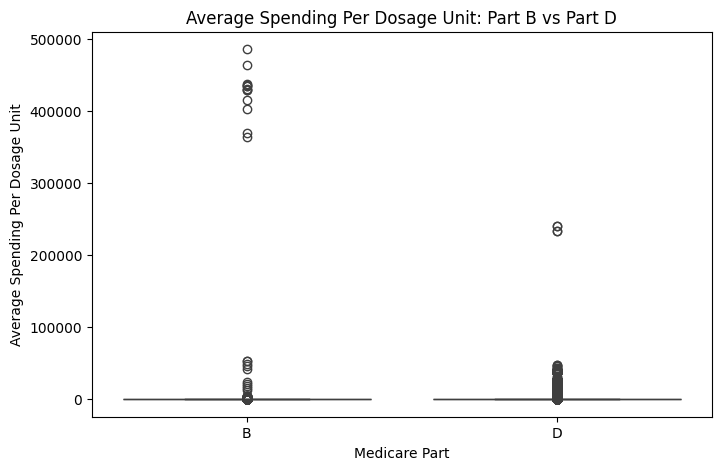

In [150]:
plt.figure(figsize=(8,5))

sns.boxplot(
    data=partBAndPartD_avgSpnd_perdsg,
    x='Part',
    y='Avg_Spend_Per_Unit'
)

plt.title("Average Spending Per Dosage Unit: Part B vs Part D")
plt.ylabel("Average Spending Per Dosage Unit")
plt.xlabel("Medicare Part")


In [151]:

#Average Spending Per Claim Unit Part B

partB_avgspend_perCLM_cols = [
    'Avg_Spndng_Per_Clm_2019',
    'Avg_Spndng_Per_Clm_2020',
    'Avg_Spndng_Per_Clm_2021',
    'Avg_Spndng_Per_Clm_2022',
    'Avg_Spndng_Per_Clm_2023']


partB_long_avgspend_perCLM = Medicare_PartB_SpendingByDrug_df.melt(
    id_vars=['Gnrc_Name'],
    value_vars=partB_avgspend_perCLM_cols,
    var_name='Year',
    value_name='Avg_Spend_Per_Claim'
)

partB_long_avgspend_perCLM['Part'] = 'B'


partB_long_avgspend_perCLM

,Gnrc_Name,Year,Avg_Spend_Per_Claim,Part
0,Hepatitis B Immune Globulin*,Avg_Spndng_Per_Clm_2019,428.974359,B
1,Rabies Immune Globulin/PF*,Avg_Spndng_Per_Clm_2019,2765.240524,B
2,Rabies Immune Globulin/PF,Avg_Spndng_Per_Clm_2019,2526.913574,B
3,Rabies Immune Globulin/PF,Avg_Spndng_Per_Clm_2019,NaN,B
4,Hepatitis A Virus Vaccine/PF*,Avg_Spndng_Per_Clm_2019,57.077578,B
...,...,...,...,...
3665,Iohexol,Avg_Spndng_Per_Clm_2023,32.720825,B
3666,Iodixanol*,Avg_Spndng_Per_Clm_2023,6.915482,B
3667,Iodixanol*,Avg_Spndng_Per_Clm_2023,11.635802,B
3668,Buprenorphine,Avg_Spndng_Per_Clm_2023,1661.877785,B


In [152]:
partB_long_avgspend_perCLM.dropna()

,Gnrc_Name,Year,Avg_Spend_Per_Claim,Part
0,Hepatitis B Immune Globulin*,Avg_Spndng_Per_Clm_2019,428.974359,B
1,Rabies Immune Globulin/PF*,Avg_Spndng_Per_Clm_2019,2765.240524,B
2,Rabies Immune Globulin/PF,Avg_Spndng_Per_Clm_2019,2526.913574,B
4,Hepatitis A Virus Vaccine/PF*,Avg_Spndng_Per_Clm_2019,57.077578,B
5,Flu Vacc TS2017-18(65yr Up)/PF*,Avg_Spndng_Per_Clm_2019,51.809803,B
...,...,...,...,...
3665,Iohexol,Avg_Spndng_Per_Clm_2023,32.720825,B
3666,Iodixanol*,Avg_Spndng_Per_Clm_2023,6.915482,B
3667,Iodixanol*,Avg_Spndng_Per_Clm_2023,11.635802,B
3668,Buprenorphine,Avg_Spndng_Per_Clm_2023,1661.877785,B


In [153]:
#Average Spending Per Claim Unit Part D

partD_avgspend_perCLM_cols = [
    'Avg_Spnd_Per_Clm_2019',
    'Avg_Spnd_Per_Clm_2020',
    'Avg_Spnd_Per_Clm_2021',
    'Avg_Spnd_Per_Clm_2022',
    'Avg_Spnd_Per_Clm_2023']


partD_long_avgspend_perCLM = Medicare_PartD_SpendingByDrug_df.melt(
    id_vars=['Gnrc_Name'],
    value_vars=partD_avgspend_perCLM_cols,
    var_name='Year',
    value_name='Avg_Spend_Per_Claim'
)

partD_long_avgspend_perCLM['Part'] = 'D'


partD_long_avgspend_perCLM

,Gnrc_Name,Year,Avg_Spend_Per_Claim,Part
0,"Pen Needle, Diabetic",Avg_Spnd_Per_Clm_2019,25.816335,D
1,"Pen Needle, Diabetic",Avg_Spnd_Per_Clm_2019,25.816335,D
2,"Pen Needle, Diabetic",Avg_Spnd_Per_Clm_2019,23.525919,D
3,"Pen Needle, Diabetic",Avg_Spnd_Per_Clm_2019,23.525919,D
4,Abacavir Sulfate,Avg_Spnd_Per_Clm_2019,237.170200,D
...,...,...,...,...
71540,Linezolid,Avg_Spnd_Per_Clm_2023,1669.528667,D
71541,Linezolid,Avg_Spnd_Per_Clm_2023,1669.528667,D
71542,Linezolid In Dextrose 5%,Avg_Spnd_Per_Clm_2023,341.309059,D
71543,Linezolid In Dextrose 5%,Avg_Spnd_Per_Clm_2023,366.352034,D


In [154]:
partD_long_avgspend_perCLM.dropna()

,Gnrc_Name,Year,Avg_Spend_Per_Claim,Part
0,"Pen Needle, Diabetic",Avg_Spnd_Per_Clm_2019,25.816335,D
1,"Pen Needle, Diabetic",Avg_Spnd_Per_Clm_2019,25.816335,D
2,"Pen Needle, Diabetic",Avg_Spnd_Per_Clm_2019,23.525919,D
3,"Pen Needle, Diabetic",Avg_Spnd_Per_Clm_2019,23.525919,D
4,Abacavir Sulfate,Avg_Spnd_Per_Clm_2019,237.170200,D
...,...,...,...,...
71540,Linezolid,Avg_Spnd_Per_Clm_2023,1669.528667,D
71541,Linezolid,Avg_Spnd_Per_Clm_2023,1669.528667,D
71542,Linezolid In Dextrose 5%,Avg_Spnd_Per_Clm_2023,341.309059,D
71543,Linezolid In Dextrose 5%,Avg_Spnd_Per_Clm_2023,366.352034,D


In [155]:
PartDandPartB_avgSpnd_PerCLM = pd.concat([partB_long_avgspend_perCLM,partD_long_avgspend_perCLM])
PartDandPartB_avgSpnd_PerCLM

,Gnrc_Name,Year,Avg_Spend_Per_Claim,Part
0,Hepatitis B Immune Globulin*,Avg_Spndng_Per_Clm_2019,428.974359,B
1,Rabies Immune Globulin/PF*,Avg_Spndng_Per_Clm_2019,2765.240524,B
2,Rabies Immune Globulin/PF,Avg_Spndng_Per_Clm_2019,2526.913574,B
3,Rabies Immune Globulin/PF,Avg_Spndng_Per_Clm_2019,NaN,B
4,Hepatitis A Virus Vaccine/PF*,Avg_Spndng_Per_Clm_2019,57.077578,B
...,...,...,...,...
71540,Linezolid,Avg_Spnd_Per_Clm_2023,1669.528667,D
71541,Linezolid,Avg_Spnd_Per_Clm_2023,1669.528667,D
71542,Linezolid In Dextrose 5%,Avg_Spnd_Per_Clm_2023,341.309059,D
71543,Linezolid In Dextrose 5%,Avg_Spnd_Per_Clm_2023,366.352034,D


In [156]:
PartDandPartB_avgSpnd_PerCLM.dropna()

,Gnrc_Name,Year,Avg_Spend_Per_Claim,Part
0,Hepatitis B Immune Globulin*,Avg_Spndng_Per_Clm_2019,428.974359,B
1,Rabies Immune Globulin/PF*,Avg_Spndng_Per_Clm_2019,2765.240524,B
2,Rabies Immune Globulin/PF,Avg_Spndng_Per_Clm_2019,2526.913574,B
4,Hepatitis A Virus Vaccine/PF*,Avg_Spndng_Per_Clm_2019,57.077578,B
5,Flu Vacc TS2017-18(65yr Up)/PF*,Avg_Spndng_Per_Clm_2019,51.809803,B
...,...,...,...,...
71540,Linezolid,Avg_Spnd_Per_Clm_2023,1669.528667,D
71541,Linezolid,Avg_Spnd_Per_Clm_2023,1669.528667,D
71542,Linezolid In Dextrose 5%,Avg_Spnd_Per_Clm_2023,341.309059,D
71543,Linezolid In Dextrose 5%,Avg_Spnd_Per_Clm_2023,366.352034,D


In [157]:
PartDandPartB_avgSpnd_PerCLM = PartDandPartB_avgSpnd_PerCLM.reset_index(drop=True)

Text(0.5, 0, 'Medicare Part')

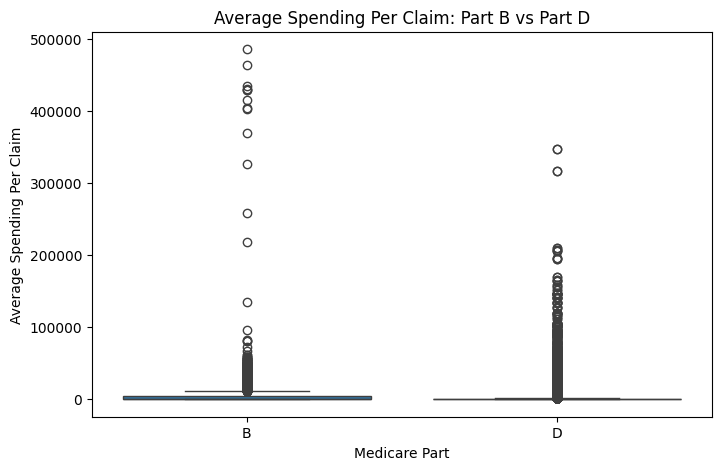

In [160]:
plt.figure(figsize=(8,5))

sns.boxplot(
    data=PartDandPartB_avgSpnd_PerCLM,
    x='Part',
    y='Avg_Spend_Per_Claim'
)

plt.title("Average Spending Per Claim: Part B vs Part D")
plt.ylabel("Average Spending Per Claim")
plt.xlabel("Medicare Part")